In [905]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import statsmodels as st
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch.utils.data as data_utils

In [906]:
data = pd.read_csv('./final.csv', index_col=0)
data['crime'] = data['Rate per 100,000 population']
data = data.drop(columns=['Rate per 100,000 population'])

def normalize(col):
    col = ''.join(col.split())
    col = ''.join(e for e in col if e.isalnum())
    out: str = col.replace(',','_').lower()
    if out[0].isdigit():
        out = '_' + out
    return out

data.rename(columns=normalize, inplace=True)
data.describe()

,year,egm,medianhouseprice,offencecount,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,presentationstoemergencydepartments201213,traveltimetonearestpublichospitalwithemergencydepartment,presentationstoemergencydepartmentsduetoinjury,category45emergencydepartmentpresentations,numberofdwellings,population,locationx,locationy,absremotenesscategory,crime
count,392.000000,3.920000e+02,3.920000e+02,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,...,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,2017.000000,4.479159e+07,6.974263e+05,8807.719388,87.531777,2427.304028,0.638564,0.915607,0.765623,0.015513,...,0.270842,25.794808,0.248449,0.567065,40813.517857,101211.071429,-0.204235,26.559082,0.589286,8604.032054
std,2.002556,3.648647e+07,4.668703e+05,6836.585681,89.737139,4388.218811,0.926171,1.249630,1.076033,0.024319,...,0.117438,23.200132,0.039385,0.076904,24837.496782,67489.684405,103.654912,82.711984,0.702344,3506.884396
min,2014.000000,1.892293e+06,1.587500e+05,387.000000,4.897709,20.822930,0.000000,0.000000,0.000000,0.000052,...,0.050232,3.930699,0.140255,0.399250,4874.000000,9873.000000,-310.285714,-81.599301,0.000000,3076.800763
25%,2015.000000,1.182050e+07,3.520722e+05,3061.750000,20.246923,79.778887,0.000000,0.000000,0.000000,0.000368,...,0.180694,8.626692,0.218529,0.513066,18526.750000,41610.000000,-23.545417,-15.651445,0.000000,6471.102274
50%,2017.000000,3.108051e+07,5.853513e+05,8011.000000,52.602954,667.579973,0.064858,0.193099,0.117857,0.002763,...,0.252941,16.079150,0.256317,0.567085,40520.000000,94681.500000,5.389039,1.222753,0.000000,8194.577278
75%,2019.000000,6.885112e+07,9.037315e+05,12515.500000,131.271874,3206.892301,1.088661,1.512202,1.384535,0.025111,...,0.375373,34.781852,0.278871,0.616169,59403.000000,151932.500000,27.746864,40.975396,1.000000,10228.073289
max,2020.000000,1.430457e+08,2.841161e+06,37886.000000,384.960766,23359.313312,3.272194,4.383425,3.737190,0.127473,...,0.553260,96.843507,0.322547,0.725373,107828.000000,298909.000000,274.239407,343.714443,2.000000,25932.263717


In [907]:
actual = data[data['year'].isin(list(range(2015, 2021)))]
actual = actual.copy()

# insert last year
for i, row in actual.iterrows():
    last = data[(data['year'] == row['year']-1) & (data['lga'] == row['lga'])].copy()
    distance = np.sqrt(row['locationx'] ** 2 + row['locationy'] ** 2)
    actual.loc[i, 'distance'] = distance
    actual.loc[i, 'last_crime'] = last['crime'].values[0]
    actual.loc[i, 'last_house'] = last['medianhouseprice'].values[0]
    actual.loc[i, 'last_egm'] = last['egm'].values[0]

actual = actual.reset_index(drop=True)
actual = actual.drop(columns=['offencecount'], axis=1)
cr = actual.pop('crime')
actual.insert(actual.shape[1], "crime", cr)
actual

,lga,year,egm,medianhouseprice,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,numberofdwellings,population,locationx,locationy,absremotenesscategory,distance,last_crime,last_house,last_egm,crime
0,whittlesea,2015,1.091612e+08,3.864022e+05,34.862554,590.075860,0.007974,0.056596,0.022594,0.005186,...,53907.0,166996.0,16.070609,18.525154,0,24.524392,7233.141209,3.567570e+05,1.035006e+08,6975.468257
1,northerngrampians,2015,1.003788e+07,1.590000e+05,179.410340,6720.196354,2.135649,2.837918,2.452597,0.000128,...,7094.0,13042.0,-179.798887,102.227446,2,206.828650,7947.694659,1.587500e+05,1.035065e+07,9876.331158
2,greatergeelong,2015,1.130210e+08,4.230712e+05,61.820207,1389.430557,0.152898,0.224843,0.182097,0.002401,...,107828.0,249716.0,-49.407904,-36.376751,0,61.354779,8127.107630,4.084374e+05,1.116281e+08,8950.482127
3,colacotway,2015,1.026330e+07,3.823333e+05,137.416278,3232.099823,1.273625,1.806754,1.531375,0.000364,...,11821.0,21429.0,-114.485347,-75.055345,1,136.894848,7259.476598,3.684167e+05,1.007489e+07,7899.199246
4,moorabool,2015,1.057564e+07,3.560000e+05,58.368445,2142.863230,0.331739,0.880712,0.598316,0.000394,...,18640.0,47165.0,-63.629211,23.520312,1,67.837170,6183.609090,3.395000e+05,1.030988e+07,6857.124858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,maribyrnong,2020,4.224321e+07,8.882343e+05,11.629266,31.347530,0.000000,0.000000,0.000000,0.068430,...,33248.0,81443.0,-7.275384,1.522394,0,7.432960,9949.698189,8.490697e+05,5.725792e+07,10239.549084
332,stonnington,2020,1.411828e+07,2.841161e+06,9.937739,23.986985,0.000000,0.000000,0.000000,0.066525,...,46028.0,96855.0,4.834074,-4.292877,0,6.465065,10326.889279,2.535312e+06,1.986235e+07,10291.270757
333,gleneira,2020,5.402530e+07,1.516358e+06,15.409791,41.586761,0.000000,0.000000,0.000000,0.032422,...,62435.0,150761.0,6.103827,-8.569276,0,10.520894,4799.397152,1.430137e+06,7.424468e+07,5086.773226
334,bayside,2020,1.022713e+07,1.744736e+06,20.118347,35.882194,0.000000,0.000000,0.000000,0.023797,...,38495.0,97337.0,5.883758,-14.204648,0,15.375000,4849.326535,1.572118e+06,1.380787e+07,5319.088156


In [1150]:
# one hot encode
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


encoder = OneHotEncoder()
encoded = actual.copy()
encoded = encoded[[
    'lga',
    'last_crime',
    'distance',
    # check if it is correlated with region
    'last_egm', 
    'last_house', 
    'crime'
  ]]

new_ = encoded.select_dtypes(include=[np.number])

idx = new_.columns.get_loc('crime')
print(idx)
# year_idx = new_.columns.get_loc('year')
# print(year_idx)
last_idx = new_.columns.get_loc('last_crime')

# scaler = MinMaxScaler(feature_range=(0,1))
# new_[new_.columns] = scaler.fit_transform(new_[new_.columns])
# standardize all

out = encoder.fit_transform(encoded[['lga']])
lga = pd.DataFrame(out.toarray())


new = pd.concat([lga, new_], axis=1)
new['crime'] /= 20000
new

4


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,last_crime,distance,last_egm,last_house,crime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,7233.141209,24.524392,1.035006e+08,3.567570e+05,0.348773
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7947.694659,206.828650,1.035065e+07,1.587500e+05,0.493817
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8127.107630,61.354779,1.116281e+08,4.084374e+05,0.447524
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7259.476598,136.894848,1.007489e+07,3.684167e+05,0.394960
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6183.609090,67.837170,1.030988e+07,3.395000e+05,0.342856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9949.698189,7.432960,5.725792e+07,8.490697e+05,0.511977
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10326.889279,6.465065,1.986235e+07,2.535312e+06,0.514564
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4799.397152,10.520894,7.424468e+07,1.430137e+06,0.254339
334,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4849.326535,15.375000,1.380787e+07,1.572118e+06,0.265954


In [1186]:
# ml model


# one hot encode

state = 42069+1
train_data: pd.DataFrame = new.sample(frac=0.7, random_state=state)
test_data = new.drop(train_data.index)

scaler_x = MinMaxScaler(feature_range=(0,1))
# scaler_y = MinMaxScaler(feature_range=(0,1))

train_y = train_data['crime'].values
train_x = train_data.drop('crime', axis=1).values
test_y = test_data['crime'].values
test_x = test_data.drop('crime', axis=1).values


scaler_x.fit(np.vstack((train_x, test_x)))
# scaler_y.fit(train_y.reshape(-1, 1))

train_x = scaler_x.transform(train_x)
# train_y = scaler_y.transform(train_y.reshape(-1, 1))
train_y = train_y


test_y = test_y
# test_y = scaler_y.transform(test_y.reshape(-1, 1))
test_x = scaler_x.transform(test_x)

print(train_x.shape, train_y.shape)

batch_size = 1

train = data_utils.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test = data_utils.TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

# Create data loaders.
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(X)
    print(y)
    # print(f"Shape of X [N, C, H, W]: {X.shape}")
    # print(f"Shape of y: {y.shape} {y.dtype}")
    break


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(train_x.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

(235, 60) (235,)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1444, 0.0599, 0.5049, 0.2080]])
tensor([0.3783])
Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=60, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [1187]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 10 == 0:
            # loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    # print(f"Avg loss: {test_loss:>8f} \n")


mse_null 1056.5406007073784 test 3037.07, train 3610.02
mse_null 1056.5406007073784 test 3008.61, train 3571.02
mse_null 1056.5406007073784 test 2969.42, train 3524.69
mse_null 1056.5406007073784 test 2936.34, train 3481.60
mse_null 1056.5406007073784 test 2910.65, train 3445.46
mse_null 1056.5406007073784 test 2868.56, train 3391.47
mse_null 1056.5406007073784 test 2876.35, train 3378.67
mse_null 1056.5406007073784 test 2771.02, train 3265.07
mse_null 1056.5406007073784 test 2731.69, train 3207.38
mse_null 1056.5406007073784 test 2670.03, train 3127.72
mse_null 1056.5406007073784 test 2626.35, train 3061.51
mse_null 1056.5406007073784 test 2556.03, train 2970.17
mse_null 1056.5406007073784 test 2544.87, train 2925.11
mse_null 1056.5406007073784 test 2443.34, train 2797.83
mse_null 1056.5406007073784 test 2359.49, train 2683.90
mse_null 1056.5406007073784 test 2289.38, train 2577.90
mse_null 1056.5406007073784 test 2220.53, train 2470.64
mse_null 1056.5406007073784 test 2178.54, train 

KeyboardInterrupt: 

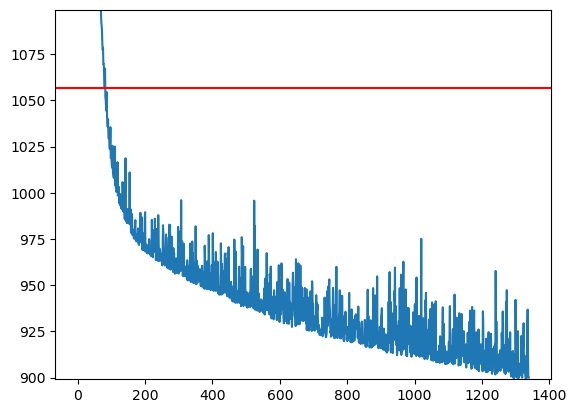

In [1188]:
import copy
import warnings
warnings.filterwarnings('ignore')


class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

null_mse = 0
def validate(test_dataloader, model, verbose=False):
    global null_mse
    
    model.eval()
    with torch.no_grad():
        i = 0
        mse = 0
        mse_null = 0
        for x, y in test_dataloader:
            x = x.clone()
            y = y.clone()
            i += 1
            labels = 56
            # labels = 0
            # old_x = scaler_x.inverse_transform(x)
            # year = old_x[:, year_idx]
            # crime = old_x[:, idx]
            # crime = scaler_y.inverse_transform(y.reshape(-1,1))
            crime = y.detach().cpu().numpy() * 20000
            old_x = x
            x = x.to(device)
            pred = model(x)
            # print('pred', pred, 'y', y)
            pred = pred.detach().cpu().numpy()
            old_x = old_x.detach().cpu().numpy()
            # out2 = np.hstack((x[:,labels:], pred.reshape(-1,1)))
            out2 = scaler_x.inverse_transform(old_x)
            # pred = scaler_y.inverse_transform(pred.reshape(-1,1))
            pred = pred * 20000

            mse += np.sum((pred - crime) ** 2)
            mse_null += np.sum((out2[:, last_idx+labels] - crime) ** 2)

    if verbose:
        # print('mse', np.sqrt(mse/(batch_size*i)), end=' ')
        print('mse_null', np.sqrt(mse_null/(batch_size*i)), end=' ')
        null_mse = np.sqrt(mse_null/(batch_size*i))
    return np.sqrt(mse/(batch_size*i))

epochs = []
loss = []


fig, ax = plt.subplots()

stopping = EarlyStopping(tolerance=20, min_delta=100)
best_val = 1e9
best_model = None
last = 0
epoch = 0
while not stopping.early_stop:
    # print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)

    test_val = validate(test_dataloader, model, True)
    train_val = validate(train_dataloader, model, False)
    print(f"test {test_val:.2f}, train {train_val:.2f}", end='\n')

    stopping(best_val, test_val)
    last = test_val

    if test_val < best_val:
        best_val = test_val
        best_model = copy.deepcopy(model)

    epochs.append(epoch)
    loss.append(test_val)
    epoch += 1
    if epoch % 10 == 0:
        ax.clear()
        ax.plot(epochs, loss)
        ax.axhline(y=null_mse, color='r')
        ax.set_ylim([best_val, best_val+200])
        fig.savefig('loss.png')


print(f"\nBest loss: {best_val:.2f}")
model = best_model

In [357]:
scaler.scale_
scaler.var_

m = scaler.mean_[idx]
s = scaler.scale_[idx]
m, s

y_m = scaler.mean_[year_idx]
s_m = scaler.scale_[year_idx]

In [192]:
x, y = next(iter(test_dataloader))
y.reshape(4, -1).shape

torch.Size([4, 1])

In [589]:
model.eval()
with torch.no_grad():
    i = 0
    target = 10
    mse = 0
    for x, y in test_dataloader:
        i += 1
        # if i > target:
        #     break

        out = np.hstack((x[:,56:], y.reshape(-1,1)))
        old_x = scaler.inverse_transform(out)
        # print(old_x)
        year = old_x[:, year_idx]
        crime = old_x[:, idx]
        # y = y * s + m

        # year = x[:,0] * s_m + y_m
        # print(encoder.inverse_transform(x[:,:56]))
        x = x.to(device)
        print(x)


        
        pred = model(x)
        pred = pred.detach().cpu().numpy()
        x = x.detach().cpu().numpy()
        out = np.hstack((x[:,56:], pred.reshape(-1,1)))
        out = scaler.inverse_transform(out)
        pred = out[:, idx]
        last = out2[:, last_idx]

        print(f'Predicted: "{pred}",\n Actual: "{crime}", Last: {last}')
        print(f'Year: "{year}"')

        mse += (pred - crime) ** 2

    print(np.sqrt(mse / i))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7707e-02, 0.0000e+00, 4.5917e-01,
         2.8705e-01, 6.5267e-01, 6.4742e-01, 6.5627e-01, 5.9151e-04, 1.6346e-03,
         1.5562e-03, 8.6199e-01, 1.8667e-01, 1.0964e-02, 8.0049e-02, 6.9897e-01,
         0.0000e+00, 1.0000e

In [1108]:
model = best_model


In [1189]:
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error


model = best_model

def null_model(train_set, test_set):
    text = f"crime ~ last_crime"
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)
    return np.sqrt(mse), model


def all_model(train_set, test_set):
    columns = [
        'ariamin',
        'publichospitals', 
        'homelessness', 
        'mentalhealth',
        'unemployedpersons', 
        'dwellingswithnomotorvehicle'
    ]

    text = f'crime ~ C(lga) + {" + ".join(columns)}'
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)

    return np.sqrt(mse), model

train_set = actual.loc[train_data.index]
test_set = actual.loc[test_data.index]
mse, null = null_model(train_set, test_set)
mse, cheating = all_model(train_set, test_set)
# print(mse)

mse = {
    'null': 0,
    'nn': 0,
    'cheating': 0
}

model.eval()
size = len(test_data.index)
for i in test_data.index:
    x = test_data.loc[i].copy()
    row = actual.loc[i]

    crime = actual.loc[i]['crime']
    features = x.drop(labels=['crime'], axis=0).values
    features = scaler_x.transform(features.reshape(1,-1))
    features = torch.tensor(features).to(device).reshape(1, -1).to(torch.float)
    pred = model(features)

    pred = pred.detach().cpu().numpy()
    features = features.detach().cpu().numpy()
    # result = np.hstack((features[:,56:], pred.reshape(-1,1)))
    # result = scaler.inverse_transform(result)
    pred = (pred * 20000).item()
    # pred = result[:, idx].item()
    null_result = null.predict(actual.loc[[i]].drop(columns=['crime'], axis=1)).values[0]
    cheating_result =cheating.predict(actual.loc[[i]].drop(columns=['crime'], axis=1)).values[0] 
    print(f'LGA: {row["lga"]}, Year: {row["year"]}')
    print(f"NN: {pred:.2f}, NULL: {null_result:.2f}, Actual: {crime:.2f}")
    mse['null'] += (null_result-crime)**2
    mse['nn'] += (pred - crime)**2
    mse['cheating'] += (cheating_result - crime)**2

print('null', np.sqrt(mse['null']/size), 'nn', np.sqrt(mse['nn']/size), 'cheating', np.sqrt(mse['cheating']/size))

LGA: northerngrampians, Year: 2015
NN: 9028.25, NULL: 8077.19, Actual: 9876.33
LGA: centralgoldfields, Year: 2015
NN: 9511.43, NULL: 8618.19, Actual: 9760.62
LGA: campaspe, Year: 2015
NN: 9276.50, NULL: 8027.31, Actual: 8196.85
LGA: greaterbendigo, Year: 2015
NN: 9204.97, NULL: 8119.69, Actual: 7652.76
LGA: swanhill, Year: 2015
NN: 11199.70, NULL: 10505.82, Actual: 10855.31
LGA: mildura, Year: 2015
NN: 11671.79, NULL: 11033.37, Actual: 11385.63
LGA: southgippsland, Year: 2015
NN: 4758.56, NULL: 4510.15, Actual: 4666.27
LGA: wangaratta, Year: 2015
NN: 9235.84, NULL: 9093.42, Actual: 8563.41
LGA: manningham, Year: 2015
NN: 3860.41, NULL: 3708.19, Actual: 3627.93
LGA: maroondah, Year: 2015
NN: 7218.94, NULL: 7140.44, Actual: 6882.67
LGA: knox, Year: 2015
NN: 6956.68, NULL: 6274.93, Actual: 6377.44
LGA: cardinia, Year: 2015
NN: 6261.01, NULL: 6554.83, Actual: 7926.50
LGA: brimbank, Year: 2015
NN: 9732.66, NULL: 8843.08, Actual: 9572.84
LGA: melton, Year: 2015
NN: 7679.10, NULL: 7744.19, Ac